Import libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
#!conda install -c conda-forge geocoder --yes
#import geocoder
print('Ready!')

Ready!


Use the pd_read.html method to scrape the Wikipedia page for postal codes and corresponding boroughs and neighbourhoods, and transfer the data to a dataframe. Exclude any boroughs that are not assigned to a postal code, and use the borough name as the neighbourhood name if it does not have one. Read geographic coordinates for each postal code from a csv file and add them to the dataframe. 

In [2]:
table = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M", header = 0)
df = table[0]
df1 = pd.DataFrame()
for i in range (len(df)):
    if df.iloc[i,1] != 'Not assigned':
        temp = df.loc[i]
        df1 = df1.append(temp)
df1.reset_index()
df1.index = range(len(df1))
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]
df1.rename(columns={'Postcode': 'PostalCode', 'Borough': 'Borough', 'Neighbourhood': 'Neighbourhood'}, inplace=True)
for i in range (len(df1)):
    if df1.iloc[i,2] == 'Not assigned':
        df1.iloc[i,2] = df1.iloc[i,1]
df2 = df1.groupby(['PostalCode','Borough'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else ', '.join(x))
csv_path = 'https://cocl.us/Geospatial_data'
csv_file = pd.read_csv(csv_path)
df2['Latitude'] = csv_file['Latitude']
df2['Longitude'] = csv_file['Longitude']
toronto_data = df2
toronto_data.shape

(103, 5)

Use geolocator to get the geographic coordinates of Toronto.

In [3]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographic coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geographic coordinates of Toronto are 43.653963, -79.387207.


Use Folium to produce a map of Toronto with the various neighbourhoods from the dataframe superimposed on it.

In [4]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, borough, neighbourhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
map_toronto

Obtain credentials for Foursquare (hidden cell)

In [5]:
# @hidden_cell
CLIENT_ID = 'EM1C5BDZ2NDWTJJQIJ003TB1P13ZDIKOKBGU0BFOW4DDHAK5' 
CLIENT_SECRET = 'D0ROEYHSYCUXH4ZAF3YNDJQFZJQGM3WDH40PN4GQTIFTCNTJ' 
VERSION = '20180605'

Define a function getNearbyVenues which gathers a maximum of 100 venues within a 500 m radius of a given location, and returns a dataframe with location data pertaining to each venue.

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    radius = 500
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)   
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']    
    return(nearby_venues)

Use getNearbyVenues to gather venue data for all of the neighbourhoods in Toronto.

In [7]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'], latitudes=toronto_data['Latitude'], longitudes=toronto_data['Longitude'])

Sort through the venues data and count the number of venues per neighbourhood. Retain the neighbourhoods that have at least 10 venues for further analysis.

In [8]:
tor_data = pd.DataFrame(columns=['PostalCode','Neighbourhood','Latitude','Longitude'])
k = 0
for i in range(len(toronto_data)):
    for j in range(len(toronto_venues)):
        if toronto_venues.iloc[j,0] == toronto_data.iloc[i,2]:
            k = k + 1
    if k >= 10:
        tor_data = tor_data.append({'PostalCode': toronto_data['PostalCode'][i], 'Neighbourhood': toronto_data['Neighbourhood'][i], 'Latitude': toronto_data['Latitude'][i], 'Longitude': toronto_data['Longitude'][i]}, ignore_index=True)
        k = 0
tor_data.shape

(62, 4)

Run getNearbyVenues on the new dataframe of neighbourhoods.

In [9]:
tor_venues = getNearbyVenues(names=tor_data['Neighbourhood'], latitudes=tor_data['Latitude'], longitudes=tor_data['Longitude'])

Perform one hot encoding on the venues data.

In [10]:
# one hot encoding
toronto_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = tor_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,...,0.01,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.01,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0
3,"Bathurst Manor, Downsview North, Wilson Heights",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.055556,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,...,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0


Define a function return_most_common_venues which identifies the top 10 venue category types for a given location, and use it to sort the neighbourhoods.

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Burger Joint,Bakery,Gym,Sushi Restaurant,Hotel
1,Agincourt,Sandwich Place,Lounge,Breakfast Spot,Clothing Store,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pharmacy,Coffee Shop,Sandwich Place,Fried Chicken Joint,Discount Store,Beer Store,Pizza Place,Fast Food Restaurant,Japanese Restaurant
3,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Pizza Place,Deli / Bodega,Bridal Shop,Shopping Mall,Fast Food Restaurant,Sandwich Place,Middle Eastern Restaurant,Diner,Supermarket
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Fast Food Restaurant,Coffee Shop,Pizza Place,Pharmacy,Butcher,Café,Restaurant,Pub,Liquor Store


Determine the optimum number of clusters for k-means clustering using the elbow method.

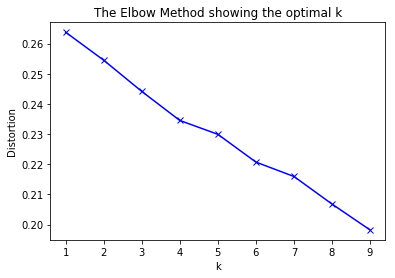

In [13]:
distortions = []
K = range(1,10)
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the elbow method, the optimum number of clusters is 4. Use this to perform k-means clustering on the sorted neighbourhoods data.

In [14]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

Merge the neighbourhoods dataframe with the newly generated top 10 venues dataframe, which now includes cluster labels.

In [15]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = tor_data
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how='right')
toronto_merged.head()

,PostalCode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Pizza Place,Rental Car Location,Breakfast Spot,Medical Center,Electronics Store,Mexican Restaurant,Spa,Coworking Space,Dog Run,Event Space
1,M1H,Cedarbrae,43.773136,-79.239476,0,Fried Chicken Joint,Bakery,Athletics & Sports,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Bank,Dumpling Restaurant,Doner Restaurant,Donut Shop
2,M1L,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,0,Bakery,Bus Line,Intersection,Soccer Field,Metro Station,Bus Station,Fast Food Restaurant,Park,Cuban Restaurant,Cupcake Shop
3,M1P,"Dorset Park, Scarborough Town Centre, Wexford ...",43.757410,-79.273304,0,Indian Restaurant,Latin American Restaurant,Vietnamese Restaurant,Gaming Cafe,Chinese Restaurant,Furniture / Home Store,Brewery,Pet Store,Ethiopian Restaurant,Empanada Restaurant
4,M1S,Agincourt,43.794200,-79.262029,0,Sandwich Place,Lounge,Breakfast Spot,Clothing Store,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


Produce a new map of Toronto using Folium with the clusters superimposed on it.

In [16]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Identify the largest cluster and produce horizontal bar charts which show the categories of the 1st, 2nd, and 3rd most common venues in this cluster.

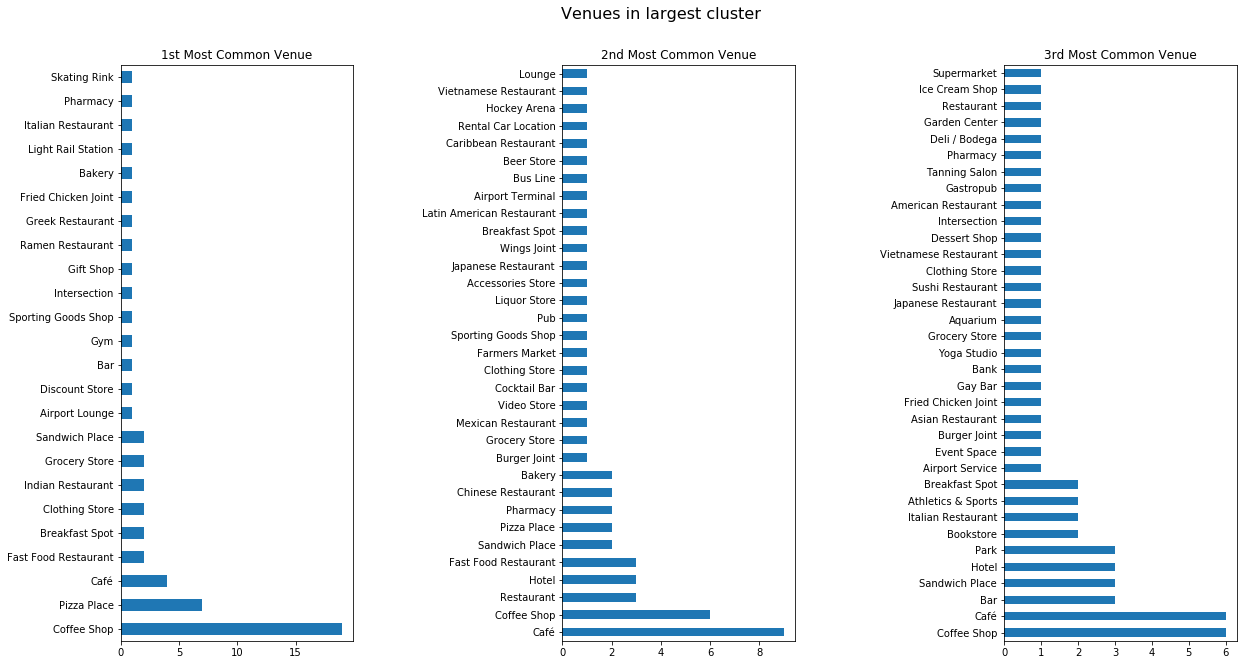

In [17]:
label_counts = toronto_merged['Cluster Labels'].value_counts()
ind = label_counts.index[0]
cluster = toronto_merged.loc[toronto_merged['Cluster Labels'] == ind, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
categorical_features = ["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue"]
fig, ax = plt.subplots(1, len(categorical_features), figsize=(20,10))
for i, categorical_feature in enumerate(cluster[categorical_features]):
    cluster[categorical_feature].value_counts().plot("barh", ax=ax[i]).set_title(categorical_feature)
fig.suptitle('Venues in largest cluster', fontsize=16)
fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.9, hspace=0.2)
fig.show()